## New DSR Downscale

##### Nov 2024 - Olson

In [2]:
# load packages
from snobedo.shortwave import TopoShade
from snobedo.input import SmrfTopo
from topocalc.viewf import viewf

from snobedo.snotel import SnotelLocations

import numpy as np
from pathlib import Path, PurePath
from datetime import datetime
import random

from osgeo import gdal, osr
import os

import matplotlib.pyplot as plt

In [3]:
## HELPER FUNCTIONS
# 
def gdal_output_bounds(topo):
        geo_transform = topo.GetGeoTransform()
        return [
            geo_transform[0],
            geo_transform[3] + geo_transform[5] * topo.RasterYSize,
            geo_transform[0] + geo_transform[1] * topo.RasterXSize,
            geo_transform[3]
        ]

# 
def time_range_for(start, end):
    time_range = np.arange(
        start,
        end,
        np.timedelta64(1, 'h'),
        dtype='datetime64[s]'
    )
    return [datetime.fromisoformat(str(r)) for r in time_range]

In [4]:
# DEM
d = "/uufs/chpc.utah.edu/common/home/u1037042/Documents/isnobal_data/toponc_ERW/topo.nc"
topo = gdal.Open(d, gdal.GA_ReadOnly)
topo
topo1 = gdal.Open(topo.GetSubDatasets()[0][0])
spatial_info = osr.SpatialReference()
spatial_info.SetFromUserInput(topo1.GetProjection())
print(spatial_info)

PROJCS["WGS84/UTMzone13N",
    GEOGCS["WGS84",
        DATUM["WGS_1984",
            SPHEROID["WGS84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-105],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32613"]]


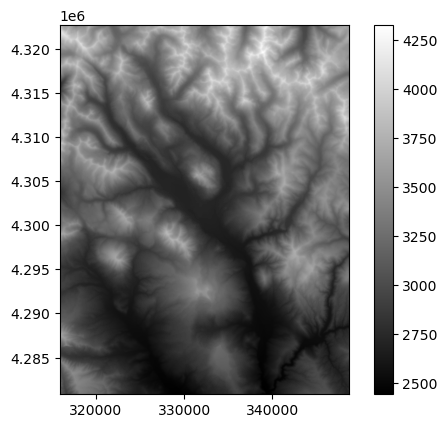

In [5]:
# plot DEM
band = topo1.GetRasterBand(1)
data = band.ReadAsArray()

# Get the geotransform information
geotransform = topo1.GetGeoTransform()

# Plot the data
plt.imshow(data, cmap='gray', extent=[geotransform[0], geotransform[0] + geotransform[1] * topo1.RasterXSize,
                                      geotransform[3] + geotransform[5] * topo1.RasterYSize, geotransform[3]])
plt.colorbar()
plt.show()

In [6]:
## Terrain
# illumination (hourly)
topo_shade = TopoShade(
        "/uufs/chpc.utah.edu/common/home/u1037042/Documents/isnobal_data/toponc_ERW/topo.nc", # saved copy of topo.nc
    "skyfield")

start_day = "2022-03-25"
end_day = "2022-03-26"

# calculate illumination angle for a day
topo_shade.calculate(
        time_range_for(start_day, end_day) # day 1 and next day
    )

In [7]:
topo_shade.illumination_angles
topo_shade.zenith

{datetime.datetime(2022, 3, 25, 6, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 7, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 8, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 9, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 10, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 11, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 12, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 13, 0, tzinfo=<UTC>): 85.2136150979844,
 datetime.datetime(2022, 3, 25, 14, 0, tzinfo=<UTC>): 73.98702951486015,
 datetime.datetime(2022, 3, 25, 15, 0, tzinfo=<UTC>): 62.76153866183569,
 datetime.datetime(2022, 3, 25, 16, 0, tzinfo=<UTC>): 52.42514488595392,
 datetime.datetime(2022, 3, 25, 17, 0, tzinfo=<UTC>): 43.796356182523105,
 datetime.datetime(2022, 3, 25, 18, 0, tzinfo=<UTC>): 38.1783088467273,
 datetime.datetime(2022, 3, 25, 19, 0, tzinfo=<UTC>): 37.033163908170806,
 datetime.datetime(2022, 3, 25, 20, 0, tzinfo=<UTC>): 40.74920344653521,
 datetime.datetime(20

In [8]:
# ViewFactor
# convert elevation to type for topocalc
dem = topo1.GetRasterBand(1).ReadAsArray()
dem2 = dem.astype(np.double)
geotransform = topo1.GetGeoTransform()
x_resolution = geotransform[1]

# skyview factor
sv = viewf(
    dem2,
    float(x_resolution)
)

# 0 - sky view factor and
# 1 - terrain configuration factor (tvf) is defined as:
#     (1 + cos(slope))/2 - sky view factor

sv[0]

array([[0.9042536 , 0.89930318, 0.870132  , ..., 0.96911202, 0.97864659,
        0.98327573],
       [0.88182575, 0.86467179, 0.82023352, ..., 0.97555423, 0.98232606,
        0.98294166],
       [0.83151735, 0.81023649, 0.78060502, ..., 0.97026602, 0.97629762,
        0.97491128],
       ...,
       [0.87627426, 0.88630186, 0.87972826, ..., 0.95132577, 0.95479809,
        0.93753301],
       [0.90767528, 0.86609543, 0.844009  , ..., 0.95440486, 0.94864426,
        0.93143442],
       [0.89439054, 0.81855303, 0.78371487, ..., 0.96786409, 0.94660467,
        0.91806853]])

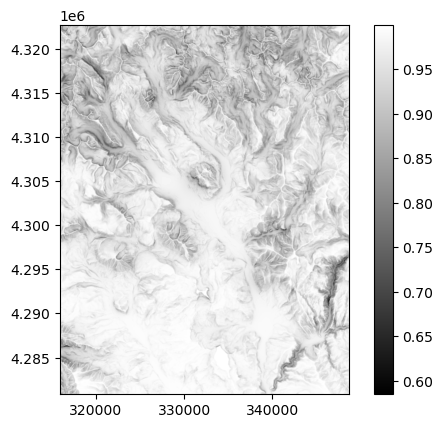

In [9]:
# plot sky view factor
geotransform = topo1.GetGeoTransform()

# Plot the data
plt.imshow(sv[0], cmap='gray', extent=[geotransform[0], geotransform[0] + geotransform[1] * topo1.RasterXSize,
                                      geotransform[3] + geotransform[5] * topo1.RasterYSize, geotransform[3]])
plt.colorbar()
plt.show()

In [10]:
os.listdir('/uufs/chpc.utah.edu/common/home/uvu-group1/olson/snow-data/HRRR/hrrr.20210401')

['hrrr.t19z.wrfsfcf06.grib2',
 'hrrr.t22z.wrfsfcf01.grib2',
 'hrrr.t00z.wrfsfcf06.grib2',
 'hrrr.t01z.wrfsfcf01.grib2',
 'hrrr.t00z.wrfsfcf01.grib2',
 'hrrr.t01z.wrfsfcf06.grib2',
 'hrrr.t21z.wrfsfcf01.grib2',
 'hrrr.t02z.wrfsfcf01.grib2',
 'hrrr.t23z.wrfsfcf01.grib2',
 'hrrr.t02z.wrfsfcf06.grib2',
 'hrrr.t21z.wrfsfcf06.grib2',
 'hrrr.t03z.wrfsfcf01.grib2',
 'hrrr.t03z.wrfsfcf06.grib2',
 'hrrr.t22z.wrfsfcf06.grib2',
 'hrrr.t04z.wrfsfcf01.grib2',
 'hrrr.t04z.wrfsfcf06.grib2',
 'hrrr.t23z.wrfsfcf06.grib2',
 'hrrr.t05z.wrfsfcf01.grib2',
 'hrrr.t05z.wrfsfcf06.grib2',
 'hrrr.t06z.wrfsfcf01.grib2',
 'hrrr.t06z.wrfsfcf06.grib2',
 'hrrr.t07z.wrfsfcf01.grib2',
 'hrrr.t07z.wrfsfcf06.grib2',
 'hrrr.t08z.wrfsfcf01.grib2',
 'hrrr.t08z.wrfsfcf06.grib2',
 'hrrr.t09z.wrfsfcf01.grib2',
 'hrrr.t09z.wrfsfcf06.grib2',
 'hrrr.t10z.wrfsfcf01.grib2',
 'hrrr.t10z.wrfsfcf06.grib2',
 'hrrr.t11z.wrfsfcf01.grib2',
 'hrrr.t11z.wrfsfcf06.grib2',
 'hrrr.t12z.wrfsfcf01.grib2',
 'hrrr.t12z.wrfsfcf06.grib2',
 'hrrr.t13

In [11]:
# Direct
## 1. Read in HRRR direct hrrr.t21z.wrfsfcf06.grib2
# hrrr_img = '/uufs/chpc.utah.edu/common/home/skiles-group1/HRRR_water_years/2022/hrrr.20220325/hrrr.t13z.wrfsfcf06.grib2'
# hrrr_img = '/uufs/chpc.utah.edu/common/home/uvu-group1/olson/snow-data/HRRR/hrrr.20220325/hrrr.t13z.wrfsfcf06.grib2'
# hrrr_img = '/uufs/chpc.utah.edu/common/home/uvu-group1/olson/snow-data/HRRR/hrrr.20210401/hrrr.t18z.wrfsfcf06.grib2' # 11 AM
hrrr_img = '/uufs/chpc.utah.edu/common/home/uvu-group1/olson/snow-data/HRRR/hrrr.20210401/hrrr.t13z.wrfsfcf06.grib2' # 1 PM
# 19 HRDS - BUT CORRESPONDS TO 20 BAND IN net_solar
# T + 6 HRS

hrdir = gdal.Open(hrrr_img)

# print info 
print(hrdir.RasterCount)
hrdir.GetRasterBand(11).GetMetadata()

12


{'GRIB_COMMENT': 'Visible Beam Downward Solar Flux [W/(m^2)]',
 'GRIB_DISCIPLINE': '0(Meteorological)',
 'GRIB_ELEMENT': 'VBDSF',
 'GRIB_FORECAST_SECONDS': '21600',
 'GRIB_IDS': 'CENTER=7(US-NCEP) SUBCENTER=0 MASTER_TABLE=2 LOCAL_TABLE=1 SIGNF_REF_TIME=1(Start_of_Forecast) REF_TIME=2021-04-01T13:00:00Z PROD_STATUS=0(Operational) TYPE=1(Forecast)',
 'GRIB_PDS_PDTN': '0',
 'GRIB_PDS_TEMPLATE_ASSEMBLED_VALUES': '4 200 2 0 83 0 0 1 6 1 0 0 255 0 0',
 'GRIB_PDS_TEMPLATE_NUMBERS': '4 200 2 0 83 0 0 0 1 0 0 0 6 1 0 0 0 0 0 255 0 0 0 0 0',
 'GRIB_REF_TIME': '1617282000',
 'GRIB_SHORT_NAME': '0-SFC',
 'GRIB_UNIT': '[W/(m^2)]',
 'GRIB_VALID_TIME': '1617303600'}

In [12]:
for i in range(1,13):
    print(hrdir.GetRasterBand(i).GetMetadata()['GRIB_COMMENT'])

Geopotential height [gpm]
Temperature [C]
Relative humidity [%]
u-component of wind [m/s]
v-component of wind [m/s]
06 hr Total precipitation [kg/(m^2)]
01 hr Total precipitation [kg/(m^2)]
Total cloud cover [%]
Total cloud cover [%]
Downward short-wave radiation flux [W/(m^2)]
Visible Beam Downward Solar Flux [W/(m^2)]
Visible Diffuse Downward Solar Flux [W/(m^2)]


In [13]:
hrdir.GetSubDatasets()

[]

In [14]:
hrdir.GetRasterBand(12).GetMetadata()['GRIB_ELEMENT']

param_names = list(map(lambda x: hrdir.GetRasterBand(x).GetMetadata()['GRIB_ELEMENT'], range(1,13)))

print(param_names)

['HGT', 'TMP', 'RH', 'UGRD', 'VGRD', 'APCP06', 'APCP01', 'TCDC', 'TCDC', 'DSWRF', 'VBDSF', 'VDDSF']


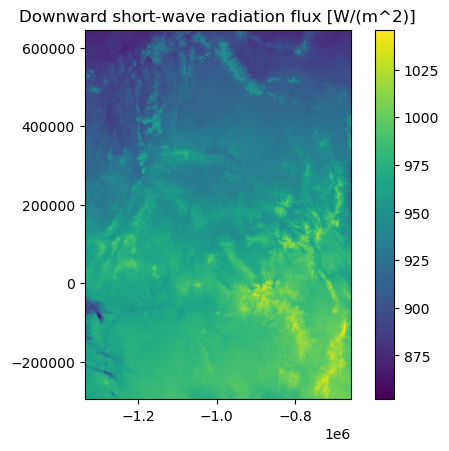

In [15]:
# plot HRRR COMBINED
bb = 10
dsw = hrdir.GetRasterBand(bb).ReadAsArray()

# Get the geotransform information
geotransform = hrdir.GetGeoTransform()

# Plot the data
plt.figure()
plt.imshow(dsw, cmap='viridis', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrdir.RasterXSize,
                                      geotransform[3] + geotransform[5] * hrdir.RasterYSize, geotransform[3]])

plt.title(hrdir.GetRasterBand(bb).GetMetadata()['GRIB_COMMENT'])
plt.colorbar() 
plt.show()

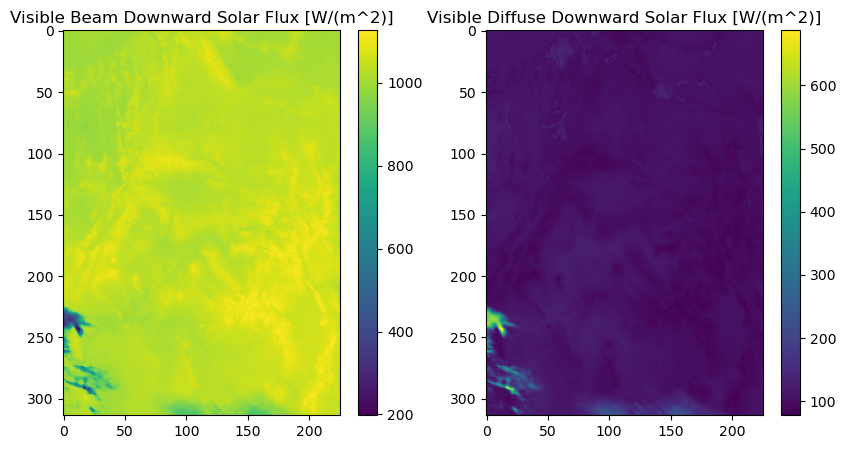

In [16]:
# PLOT OTHER VARS

# DIRECT BEAM
Ib = hrdir.GetRasterBand(11).ReadAsArray()

# DIFFUSE
Id = hrdir.GetRasterBand(12).ReadAsArray()


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot raster data and store the returned image object
im1 = axs[0].imshow(Ib, cmap='viridis')
axs[0].set_title(hrdir.GetRasterBand(11).GetMetadata()['GRIB_COMMENT'])

im2 = axs[1].imshow(Id, cmap='viridis')
axs[1].set_title(hrdir.GetRasterBand(12).GetMetadata()['GRIB_COMMENT'])

# Add colorbars
fig.colorbar(im1, ax=axs[0])  # Colorbar for the first subplot
fig.colorbar(im2, ax=axs[1])  # Colorbar for the second subplot

plt.show()

In [17]:
for i in range(1,13):
    print(hrdir.GetRasterBand(i).GetMetadata()['GRIB_COMMENT'])

Geopotential height [gpm]
Temperature [C]
Relative humidity [%]
u-component of wind [m/s]
v-component of wind [m/s]
06 hr Total precipitation [kg/(m^2)]
01 hr Total precipitation [kg/(m^2)]
Total cloud cover [%]
Total cloud cover [%]
Downward short-wave radiation flux [W/(m^2)]
Visible Beam Downward Solar Flux [W/(m^2)]
Visible Diffuse Downward Solar Flux [W/(m^2)]


hrrr.t13z.wrfsfcf06.grib2
-194.58046072380472
-0.206074883442515
-143.98012875030935


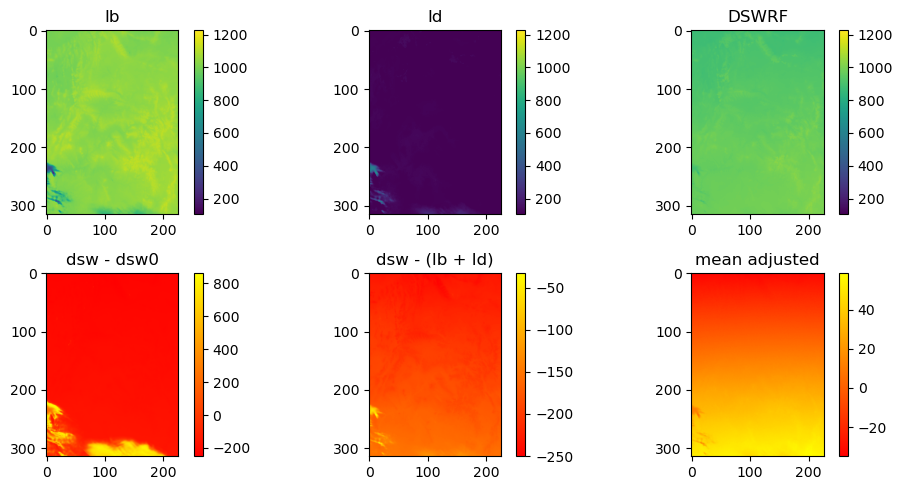

In [18]:

time = 6
hrrr_img = f'/uufs/chpc.utah.edu/common/home/uvu-group1/olson/snow-data/HRRR/hrrr.20210401/hrrr.t{time + 7}z.wrfsfcf06.grib2' # 1 PM 
hrdir = gdal.Open(hrrr_img)
print(os.path.basename(hrrr_img))

# simple mod
gpm = hrdir.GetRasterBand(1).ReadAsArray() # Elelvation
temp = hrdir.GetRasterBand(2).ReadAsArray() # Temperature C
rh = hrdir.GetRasterBand(3).ReadAsArray() # RH %
cld = hrdir.GetRasterBand(9).ReadAsArray() # CLOUDS
dsw = hrdir.GetRasterBand(10).ReadAsArray() #
Ib = hrdir.GetRasterBand(11).ReadAsArray() # DIRECT BEAM
Id = hrdir.GetRasterBand(12).ReadAsArray() # DIFFUSE

# models
Ib_adj = Ib * (1 - cld/100)
alph = 0.1 # α is an empirical scaling factor (typically between 0.1 and 0.5), representing how cloud cover increases diffuse radiation.
Id_adj = Id * (1 + alph * cld/100) 

dsw0 = Ib_adj + Id_adj

var1 =  dsw0
var2 = dsw
var3 = dsw0
var4 = dsw

# Determine the color limits (vmin and vmax) based on both datasets
vmin = min(var1.min(), var2.min(), var3.min(), var4.min())
vmax = max(var1.max(), var2.max(), var3.max(), var4.min())

# Plot raster data and store the returned image object
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

# Inputs

im1 = axs[0, 0].imshow(Ib, cmap='viridis', vmin=vmin, vmax=vmax)  # Adjusted model
axs[0, 0].set_title('Ib')
im2 = axs[0, 1].imshow(Id, cmap='viridis', vmin=vmin, vmax=vmax)  # Original DSWRF
axs[0, 1].set_title('Id')
im3 = axs[0, 2].imshow(dsw, cmap='viridis', vmin=vmin, vmax=vmax)  # Original DSWRF
axs[0, 2].set_title('DSWRF')

# Difference models
diff_img = dsw - (Ib + Id)
print(diff_img.mean())
diff_perc = (dsw - (Ib + Id) ) / dsw
print(diff_perc.mean())
diff_img2 = dsw - dsw0
print(diff_img2.mean())

Ibd1 = ((Ib + Id) + diff_img )



im4 = axs[1, 0].imshow(dsw - dsw0, cmap='autumn')  # Difference between DSWRF and Model
axs[1, 0].set_title('dsw - dsw0')
im5 = axs[1, 1].imshow((dsw - (Ib + Id)), cmap='autumn')  # Relative Humidity
axs[1, 1].set_title('dsw - (Ib + Id)')
im6 = axs[1, 2].imshow((dsw - (Ib*0.8 + Id*1)), cmap='autumn')  # Relative Humidity
axs[1, 2].set_title('mean adjusted')

# Add colorbars
fig.colorbar(im1, ax=axs[0, 0]) 
fig.colorbar(im2, ax=axs[0, 1]) 
fig.colorbar(im3, ax=axs[0, 2]) 
fig.colorbar(im4, ax=axs[1, 0]) 
fig.colorbar(im5, ax=axs[1, 1]) 
fig.colorbar(im6, ax=axs[1, 2]) 

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


In [19]:
diff_img = dsw - (Ib + Id)
print(diff_img.mean())
diff_img2 = dsw - dsw0
print(diff_img2.mean())

-194.58046072380472
-143.98012875030935


hrrr.t13z.wrfsfcf06.grib2


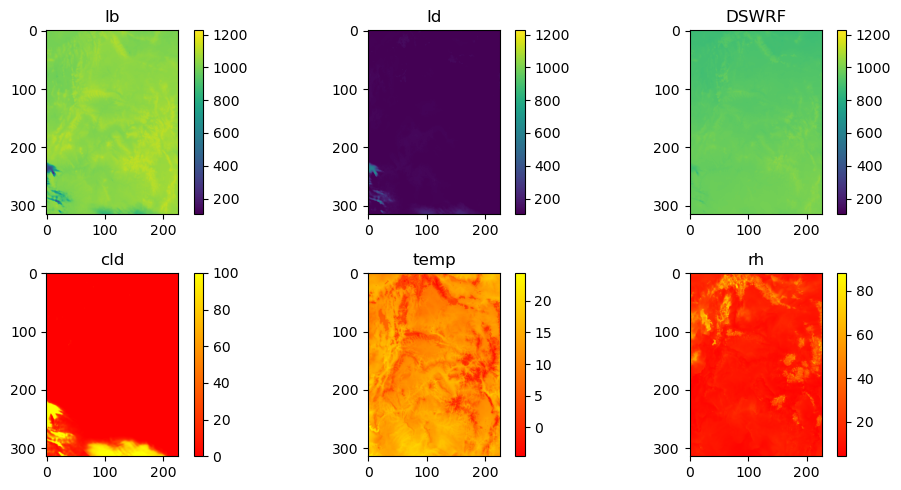

In [20]:
time = 6
hrrr_img = f'/uufs/chpc.utah.edu/common/home/uvu-group1/olson/snow-data/HRRR/hrrr.20210401/hrrr.t{time + 7}z.wrfsfcf06.grib2' # 1 PM 
hrdir = gdal.Open(hrrr_img)
print(os.path.basename(hrrr_img))

# simple mod
gpm = hrdir.GetRasterBand(1).ReadAsArray() # Elelvation
temp = hrdir.GetRasterBand(2).ReadAsArray() # Temperature C
rh = hrdir.GetRasterBand(3).ReadAsArray() # RH %
cld = hrdir.GetRasterBand(9).ReadAsArray() # CLOUDS
dsw = hrdir.GetRasterBand(10).ReadAsArray() #
Ib = hrdir.GetRasterBand(11).ReadAsArray() # DIRECT BEAM
Id = hrdir.GetRasterBand(12).ReadAsArray() # DIFFUSE


# Plot raster data and store the returned image object
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

# Inputs

im1 = axs[0, 0].imshow(Ib, cmap='viridis', vmin=vmin, vmax=vmax)  # Adjusted model
axs[0, 0].set_title('Ib')
im2 = axs[0, 1].imshow(Id, cmap='viridis', vmin=vmin, vmax=vmax)  # Original DSWRF
axs[0, 1].set_title('Id')
im3 = axs[0, 2].imshow(dsw, cmap='viridis', vmin=vmin, vmax=vmax)  # Original DSWRF
axs[0, 2].set_title('DSWRF')


im4 = axs[1, 0].imshow(cld, cmap='autumn')  # Difference between DSWRF and Model
axs[1, 0].set_title('cld')
im5 = axs[1, 1].imshow(temp, cmap='autumn')  # Relative Humidity
axs[1, 1].set_title('temp')
im6 = axs[1, 2].imshow(rh, cmap='autumn')  # Relative Humidity
axs[1, 2].set_title('rh')

# Add colorbars
fig.colorbar(im1, ax=axs[0, 0]) 
fig.colorbar(im2, ax=axs[0, 1]) 
fig.colorbar(im3, ax=axs[0, 2]) 
fig.colorbar(im4, ax=axs[1, 0]) 
fig.colorbar(im5, ax=axs[1, 1]) 
fig.colorbar(im6, ax=axs[1, 2]) 

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

In [21]:
idirdif = Ib + Id
iddm = (Id - idirdif) / (idirdif)
print(iddm.mean())
print( ((Id/idirdif) ).mean() ) # 9.6%

print( ((Id/idirdif) + Ib/idirdif).mean() )


-0.9038363012173981
0.09616369878260181
1.0


hrrr.t16z.wrfsfcf06.grib2
Local time: 10
UTC time: 17
Grib timestamp: 16
diffuse mean fraction 12 %
direct beam mean fraction 88 %


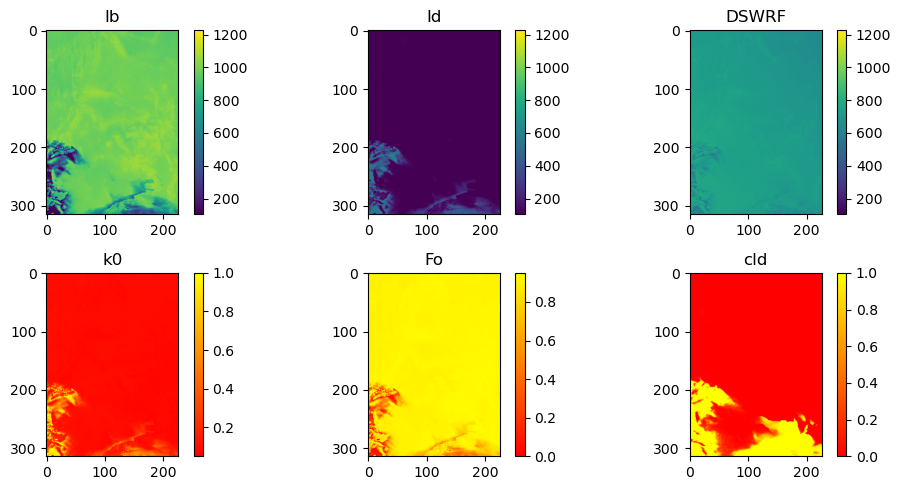

In [22]:
base_path = '/uufs/chpc.utah.edu/common/home/uvu-group1/olson/snow-data/HRRR/hrrr.20210401'

# define
time = 10
if (time < 4):
    hrrr_img = f'{base_path}/hrrr.t0{time + 6}z.wrfsfcf06.grib2' # 1 PM 
elif(time > 17):
    print("Next day error")
    ! # stops code
else:
    hrrr_img = f'{base_path}/hrrr.t{time + 6}z.wrfsfcf06.grib2' #  

hrdir = gdal.Open(hrrr_img)
print(os.path.basename(hrrr_img))
print(f'Local time: {time}')
print(f'UTC time: {time+ 7}')
print(f'Grib timestamp: {time + 6}')

# simple mod
gpm = hrdir.GetRasterBand(1).ReadAsArray() # Elelvation
temp = hrdir.GetRasterBand(2).ReadAsArray() # Temperature C
rh = hrdir.GetRasterBand(3).ReadAsArray() # RH %
cld = hrdir.GetRasterBand(9).ReadAsArray() # CLOUDS
dsw = hrdir.GetRasterBand(10).ReadAsArray() #
Ib = hrdir.GetRasterBand(11).ReadAsArray() # DIRECT BEAM
Id = hrdir.GetRasterBand(12).ReadAsArray() # DIFFUSE


# Plot raster data and store the returned image object
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

# Inputs

im1 = axs[0, 0].imshow(Ib, cmap='viridis', vmin=vmin, vmax=vmax)  # Adjusted model
axs[0, 0].set_title('Ib')
im2 = axs[0, 1].imshow(Id, cmap='viridis', vmin=vmin, vmax=vmax)  # Original DSWRF
axs[0, 1].set_title('Id')
im3 = axs[0, 2].imshow(dsw, cmap='viridis', vmin=vmin, vmax=vmax)  # Original DSWRF
axs[0, 2].set_title('DSWRF')

idirdif = Ib + Id
idm = (Id) / (idirdif)
ibm = (Ib) / (idirdif)
print("diffuse mean fraction " + str(round(idm.mean() * 100)) + " %")
print("direct beam mean fraction " + str(round(ibm.mean() * 100)) + " %")


im4 = axs[1, 0].imshow(idm, cmap='autumn')  # Difference between DSWRF and Model
axs[1, 0].set_title('k0')
im5 = axs[1, 1].imshow(ibm, cmap='autumn')  # Relative Humidity
axs[1, 1].set_title('Fo')
im6 = axs[1, 2].imshow(cld/100, cmap='autumn')  # Relative Humidity
axs[1, 2].set_title('cld')

# Add colorbars
fig.colorbar(im1, ax=axs[0, 0]) 
fig.colorbar(im2, ax=axs[0, 1]) 
fig.colorbar(im3, ax=axs[0, 2]) 
fig.colorbar(im4, ax=axs[1, 0]) 
fig.colorbar(im5, ax=axs[1, 1]) 
fig.colorbar(im6, ax=axs[1, 2]) 

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

In [23]:
time = 6
utc = time + 7
topo_shade.zenith[list(topo_shade.zenith)[time]]

0

In [24]:
from datetime import datetime, timezone

def utc_to_local(utc_dt):
    return utc_dt.replace(tzinfo=timezone.utc).astimezone(tz=None)

print(utc_to_local(list(topo_shade.zenith)[time]))

dt = list(topo_shade.zenith)[time]
dt.hour

2022-03-25 06:00:00-06:00


12

In [25]:
local_time = 6
utc_time  = local_time + 7
hrrr_img = f'/uufs/chpc.utah.edu/common/home/uvu-group1/olson/snow-data/HRRR/hrrr.20210401/hrrr.t{utc_time}z.wrfsfcf06.grib2' # 1 PM 
hrdir = gdal.Open(hrrr_img)
print(os.path.basename(hrrr_img))

# grib goes from 0 - 23
# zenith is in local time

list(topo_shade.zenith)[local_time] # should be 1 hr off // might not work
dt = list(topo_shade.zenith)[local_time]
print(dt.hour)


# # simple mod
# gpm = hrdir.GetRasterBand(1).ReadAsArray() # Elelvation
# dsw = hrdir.GetRasterBand(10).ReadAsArray() #
# Ib = hrdir.GetRasterBand(11).ReadAsArray() # DIRECT BEAM
# Id = hrdir.GetRasterBand(12).ReadAsArray() # DIFFUSE

hrrr.t13z.wrfsfcf06.grib2
12


In [26]:
topo_shade.zenith

{datetime.datetime(2022, 3, 25, 6, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 7, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 8, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 9, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 10, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 11, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 12, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 13, 0, tzinfo=<UTC>): 85.2136150979844,
 datetime.datetime(2022, 3, 25, 14, 0, tzinfo=<UTC>): 73.98702951486015,
 datetime.datetime(2022, 3, 25, 15, 0, tzinfo=<UTC>): 62.76153866183569,
 datetime.datetime(2022, 3, 25, 16, 0, tzinfo=<UTC>): 52.42514488595392,
 datetime.datetime(2022, 3, 25, 17, 0, tzinfo=<UTC>): 43.796356182523105,
 datetime.datetime(2022, 3, 25, 18, 0, tzinfo=<UTC>): 38.1783088467273,
 datetime.datetime(2022, 3, 25, 19, 0, tzinfo=<UTC>): 37.033163908170806,
 datetime.datetime(2022, 3, 25, 20, 0, tzinfo=<UTC>): 40.74920344653521,
 datetime.datetime(20

In [27]:
# from snobedo.lib.dask_utils import start_cluster, client_ip_and_port

# client = start_cluster(8, 24)
# client_ip_and_port(client)

In [28]:
# import xarray as xr

# grib_day = xr.open_mfdataset(
#     f'{SHARED_STORE}/erw_isnobal/{water_year}/erw/run*/smrf_energy*.nc',
#     parallel=True, chunks={'time': 24}, #, 'y' :10, 'x': 10},
# )
# grib_day

In [29]:
# HRRR_solar = xr.open_mfdataset(
#     f'{SHARED_STORE}/erw_isnobal/{water_year}/erw_hrrr_solar_modis_cubic/run*/net_solar.nc',
#     parallel=True, chunks={'time': 24}, # 'y' :10, 'x': 10},
#     drop_variables=['DSWRF', 'illumination_angle'],
# )

In [30]:
## 2. Reproject (warp)
# extract epsg code from dem
epsg_code = spatial_info.GetAuthorityName(None) + ":" + spatial_info.GetAuthorityCode(None)

# temp file
mem_hrrr_file = '/vsimem/grib_%i.tif' % random.getrandbits(32)

# warp options for topo files
options = gdal.WarpOptions(
            dstSRS=epsg_code,
            outputBoundsSRS=epsg_code,
            outputBounds= gdal_output_bounds(topo1),
            xRes=topo1.GetGeoTransform()[1],
            yRes=topo1.GetGeoTransform()[1],
            multithread=True,
        )

# warp file, original, options=topo1
gdal.Warp(mem_hrrr_file, hrrr_img, options=options)

## 3.5 reopen (save)
hrrr_warp = gdal.Open(mem_hrrr_file, gdal.GA_ReadOnly)
hrrr_warp

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc24c093360> >

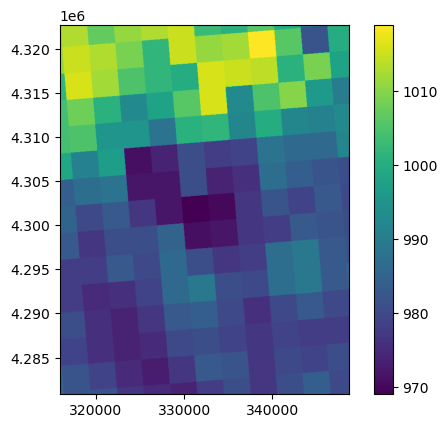

In [31]:
# Plot warped HRRR
band_hrrr = hrrr_warp.GetRasterBand(10) # 10th variable is sw
data_hrrr = band_hrrr.ReadAsArray()

# Get the geotransform information
geotransform = hrrr_warp.GetGeoTransform()

# Plot the data
plt.figure()
plt.imshow(data_hrrr, cmap='viridis', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrrr_warp.RasterXSize,
                                      geotransform[3] + geotransform[5] * hrrr_warp.RasterYSize, geotransform[3]])
plt.colorbar()
plt.show()

In [32]:
# 13 UTC
list(topo_shade.illumination_angles)[10]

datetime.datetime(2022, 3, 25, 16, 0, tzinfo=<UTC>)

In [33]:
# check dimensions
cos_inc = topo_shade.illumination_angles[list(topo_shade.illumination_angles)[10]]
cos_inc.shape

(837, 656)

In [34]:
# plot illumination

# # Get the geotransform information
# geotransform = hrrr_warp.GetGeoTransform()

# # Plot the data
# plt.figure()
# plt.imshow(cos_inc, cmap='grey', extent=[geotransform[0], geotransform[0] + geotransform[1] * hrrr_warp.RasterXSize,
#                                       geotransform[3] + geotransform[5] * hrrr_warp.RasterYSize, geotransform[3]])
# plt.colorbar()
# plt.show()

diffuse mean fraction 7 %
direct beam mean fraction 93 %


NameError: name 'k' is not defined

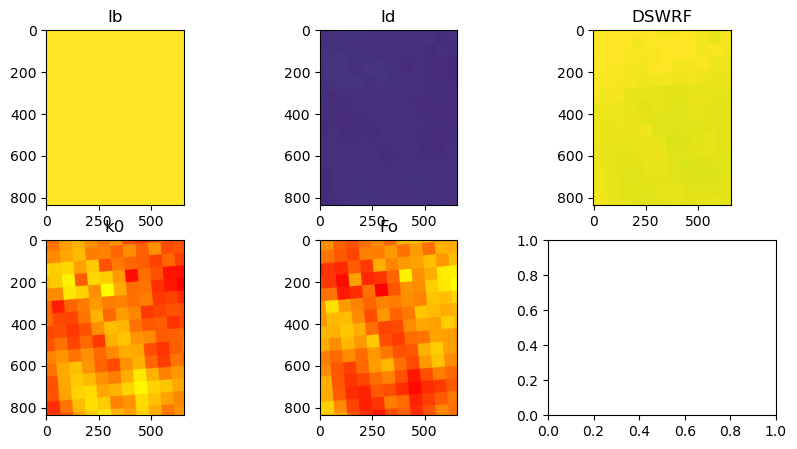

In [49]:


# simple mod
gpm = hrrr_warp.GetRasterBand(1).ReadAsArray() # Elelvation
temp = hrrr_warp.GetRasterBand(2).ReadAsArray() # Temperature C
rh = hrrr_warp.GetRasterBand(3).ReadAsArray() # RH %
cld = hrrr_warp.GetRasterBand(9).ReadAsArray() # CLOUDS
dsw = hrrr_warp.GetRasterBand(10).ReadAsArray() #
Ib = hrrr_warp.GetRasterBand(11).ReadAsArray() # DIRECT BEAM
Id = hrrr_warp.GetRasterBand(12).ReadAsArray() # DIFFUSE


# Plot raster data and store the returned image object
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

# Inputs

im1 = axs[0, 0].imshow(Ib, cmap='viridis', vmin=vmin, vmax=vmax)  # Adjusted model
axs[0, 0].set_title('Ib')
im2 = axs[0, 1].imshow(Id, cmap='viridis', vmin=vmin, vmax=vmax)  # Original DSWRF
axs[0, 1].set_title('Id')
im3 = axs[0, 2].imshow(dsw, cmap='viridis', vmin=vmin, vmax=vmax)  # Original DSWRF
axs[0, 2].set_title('DSWRF')

idirdif = Ib + Id
idm = (Id) / (idirdif)
ibm = (Ib) / (idirdif)
print("diffuse mean fraction " + str(round(idm.mean() * 100)) + " %")
print("direct beam mean fraction " + str(round(ibm.mean() * 100)) + " %")

im4 = axs[1, 0].imshow(idm, cmap='autumn')  # Difference between DSWRF and Model
axs[1, 0].set_title('k0')
im5 = axs[1, 1].imshow(ibm, cmap='autumn')  # Relative Humidity
axs[1, 1].set_title('Fo')
im6 = axs[1, 2].imshow(cld/100, cmap='autumn')  # Relative Humidity
axs[1, 2].set_title('cld')

# Add colorbars
fig.colorbar(im1, ax=axs[0, 0]) 
fig.colorbar(im2, ax=axs[0, 1]) 
fig.colorbar(im3, ax=axs[0, 2]) 
fig.colorbar(im4, ax=axs[1, 0]) 
fig.colorbar(im5, ax=axs[1, 1]) 
fig.colorbar(im6, ax=axs[1, 2]) 

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

In [36]:
# validate with model output (time)

In [37]:
topo_shade.zenith

{datetime.datetime(2022, 3, 25, 6, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 7, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 8, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 9, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 10, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 11, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 12, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 13, 0, tzinfo=<UTC>): 85.2136150979844,
 datetime.datetime(2022, 3, 25, 14, 0, tzinfo=<UTC>): 73.98702951486015,
 datetime.datetime(2022, 3, 25, 15, 0, tzinfo=<UTC>): 62.76153866183569,
 datetime.datetime(2022, 3, 25, 16, 0, tzinfo=<UTC>): 52.42514488595392,
 datetime.datetime(2022, 3, 25, 17, 0, tzinfo=<UTC>): 43.796356182523105,
 datetime.datetime(2022, 3, 25, 18, 0, tzinfo=<UTC>): 38.1783088467273,
 datetime.datetime(2022, 3, 25, 19, 0, tzinfo=<UTC>): 37.033163908170806,
 datetime.datetime(2022, 3, 25, 20, 0, tzinfo=<UTC>): 40.74920344653521,
 datetime.datetime(20

In [38]:
# # topo_shade.zenith
# # 7-20 > 0 ()

# time_step = 20

# # DSWRF
# hrrr_smrf_00 = gdal.Open(hrrr_img) 
# hrrr_dswrf = hrrr_smrf_00.GetRasterBand(time_step).ReadAsArray()

# # SOLAR info
# match_solar = time_step - 7
# dt = list(topo_shade.zenith)[match_solar]
# zenith_hr = topo_shade.zenith[list(topo_shade.zenith)[match_solar]] # zenith angle
# cosi_hr = topo_shade.illumination_angles[list(topo_shade.illumination_angles)[match_solar]] # cos(incidence)
# print(f"Grib timestep: {time_step} (-1 start of hour)")
# print(f"Zenith timestep: {match_solar}")
# print(f"Zenith solar Hour: {dt.hour}")
# print(f"Zenith Angle: {zenith_hr}")
# # print(f"Cos Incidence Angle: {cosi_hr}")

In [39]:
local_time = 7
utc_time  = local_time + 7
hrrr_img = f'/uufs/chpc.utah.edu/common/home/uvu-group1/olson/snow-data/HRRR/hrrr.20210401/hrrr.t{utc_time}z.wrfsfcf06.grib2' # 1 PM 
hrdir = gdal.Open(hrrr_img)
print(os.path.basename(hrrr_img))
# grib goes from 0 - 23
# zenith is in local time
list(topo_shade.zenith)[local_time] # should be 1 hr off // might not work
dt = list(topo_shade.zenith)[local_time]
print(dt.hour)

hrrr.t14z.wrfsfcf06.grib2
13


In [40]:
c = np.stack((Ib,Id), axis=0)
c.shape

(2, 837, 656)

In [41]:
topo_shade.zenith[list(topo_shade.zenith)[local_time]]
# topo_shade.zenith[list(topo_shade.zenith)[utc_time]]
# topo_shade.zenith.keys()

85.2136150979844

hrrr.t17z.wrfsfcf06.grib2
16
Grib timestep: 17 (-1 start of hour)
Zenith local timestep: 10
Zenith local Hour: 16
Zenith Angle: 52.42514488595392
diffuse mean fraction 72 %
direct beam mean fraction 28 %
mean k0: 0.7235328353884986
mean F0: 0.2764671646115015
mean Ib: 85.36645953750714
mean Id: 211.27268699502457
mean dsw: 530.063715578067


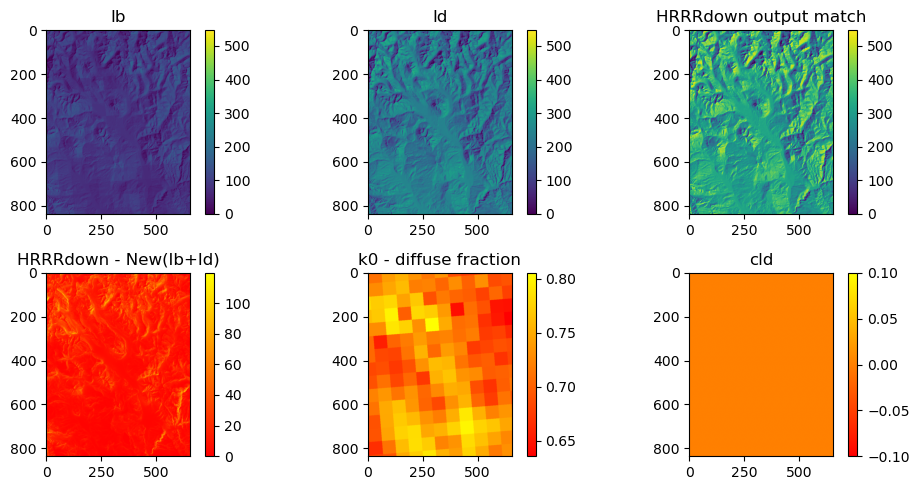

In [48]:
## TIMESTEP
local_time = 10 #7-20 daylight hours (12 is 1800 - beyond zenith is 0)
utc_time  = local_time + 7
hrrr_img = f'/uufs/chpc.utah.edu/common/home/uvu-group1/olson/snow-data/HRRR/hrrr.20210401/hrrr.t{utc_time}z.wrfsfcf06.grib2' # 1 PM 
hrdir = gdal.Open(hrrr_img)
print(os.path.basename(hrrr_img))
# grib goes from 0 - 23
# zenith is in local time
list(topo_shade.zenith)[local_time] # should be 1 hr off // might not work
dt = list(topo_shade.zenith)[local_time]
print(dt.hour)

dt = list(topo_shade.zenith)[local_time]
zenith_hr = topo_shade.zenith[list(topo_shade.zenith)[local_time]] # zenith angle
cosi_hr = topo_shade.illumination_angles[list(topo_shade.illumination_angles)[local_time]] # cos(incidence)
print(f"Grib timestep: {utc_time} (-1 start of hour)")
print(f"Zenith local timestep: {local_time}")
print(f"Zenith local Hour: {dt.hour}")
print(f"Zenith Angle: {zenith_hr}")


## 2. Reproject (warp)
# extract epsg code from dem
epsg_code = spatial_info.GetAuthorityName(None) + ":" + spatial_info.GetAuthorityCode(None)

# temp file
mem_hrrr_file = '/vsimem/grib_%i.tif' % random.getrandbits(32)

# warp options for topo files
options = gdal.WarpOptions(
            dstSRS=epsg_code,
            outputBoundsSRS=epsg_code,
            outputBounds= gdal_output_bounds(topo1),
            xRes=topo1.GetGeoTransform()[1],
            yRes=topo1.GetGeoTransform()[1],
            multithread=True,
        )

# warp file, original, options=topo1
gdal.Warp(mem_hrrr_file, hrrr_img, options=options)

## 3.5 reopen (save)
hrrr_warp = gdal.Open(mem_hrrr_file, gdal.GA_ReadOnly)


# LOAD IN DATA
gpm = hrrr_warp.GetRasterBand(1).ReadAsArray() # Elelvation
temp = hrrr_warp.GetRasterBand(2).ReadAsArray() # Temperature C
rh = hrrr_warp.GetRasterBand(3).ReadAsArray() # RH %
cld = hrrr_warp.GetRasterBand(9).ReadAsArray() # CLOUDS
dsw = hrrr_warp.GetRasterBand(10).ReadAsArray() #
Ib = hrrr_warp.GetRasterBand(11).ReadAsArray() # DIRECT BEAM
Id = hrrr_warp.GetRasterBand(12).ReadAsArray() # DIFFUSE

# cosi = topo_shade.zenith[list(topo_shade.zenith)[local_time]]

# check dimensions
# cos_inc = topo_shade.illumination_angles[list(topo_shade.illumination_angles)[10]]


# Inputs
idirdif = Ib + Id
k0 = (Id) / (idirdif) * 10
F0 = 1 - k0
# F0 = (Ib) / (idirdif)
print("diffuse mean fraction " + str(round(k0.mean() * 100)) + " %")
print("direct beam mean fraction " + str(round(F0.mean() * 100)) + " %")

Ib = (F0 * dsw) * cosi_hr
Id = (k0 * dsw) * sv[0] * cosi_hr
dsw_new = (Ib + Id)
dsw2 = dsw * cosi_hr

print(f'mean k0: {k0.mean()}')
print(f'mean F0: {F0.mean()}')
print(f'mean Ib: {Ib.mean()}')
print(f'mean Id: {Id.mean()}')
print(f'mean dsw: {dsw.mean()}')

# plot colors
var1 = Ib
var2 = Id
var3 = dsw2
var4 = dsw_new

# Determine the color limits (vmin and vmax) based on both datasets
vmin = min(var1.min(), var2.min(), var3.min(), var4.min())
vmax = max(var1.max(), var2.max(), var3.max(), var4.min())

## PLOT
# Plot raster data and store the returned image object
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
# FIRST ROW
im1 = axs[0, 0].imshow(Ib, cmap='viridis', vmin=vmin, vmax=vmax)  # Beam
axs[0, 0].set_title('Ib')
im2 = axs[0, 1].imshow(Id, cmap='viridis', vmin=vmin, vmax=vmax)  # DIffuse
axs[0, 1].set_title('Id')
im3 = axs[0, 2].imshow(dsw2, cmap='viridis', vmin=vmin, vmax=vmax)  # Match SMRF
axs[0, 2].set_title('HRRRdown output match')
# SECOND ROW
im4 = axs[1, 0].imshow(dsw2 - dsw_new , cmap='autumn')  # Difference between DSWRF and Model
axs[1, 0].set_title('HRRRdown - New(Ib+Id)')
im5 = axs[1, 1].imshow(k0, cmap='autumn')  # DIffuse fraction
axs[1, 1].set_title('k0 - diffuse fraction')
im6 = axs[1, 2].imshow(cld/100, cmap='autumn')  # clouds
axs[1, 2].set_title('cld')

# Add colorbars
fig.colorbar(im1, ax=axs[0, 0]) 
fig.colorbar(im2, ax=axs[0, 1]) 
fig.colorbar(im3, ax=axs[0, 2]) 
fig.colorbar(im4, ax=axs[1, 0]) 
fig.colorbar(im5, ax=axs[1, 1]) 
fig.colorbar(im6, ax=axs[1, 2]) 

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

In [43]:
# HRR 00 - 23
# zenith #7-20 daylight hours
# topo_shade.zenith

# os.listdir('/uufs/chpc.utah.edu/common/home/uvu-group1/olson/snow-data/HRRR/hrrr.20210401/')

In [44]:
import math
def stack_hrrr(local_time):
    ## TIMESTEP
    # local_time = 15 #7-20 daylight hours
    utc_time  = local_time + 7
    hrrr_img = f'/uufs/chpc.utah.edu/common/home/uvu-group1/olson/snow-data/HRRR/hrrr.20210401/hrrr.t{utc_time}z.wrfsfcf06.grib2' # 1 PM 
    # next day
    utc_time2 = abs(utc_time - 23)
    hrrr_img2 = f'/uufs/chpc.utah.edu/common/home/uvu-group1/olson/snow-data/HRRR/hrrr.20210402/hrrr.t0{utc_time2}z.wrfsfcf06.grib2' # 1 PM 
    if local_time > 16:
        hrdir = gdal.Open(hrrr_img)    
    else:
        hrdir = gdal.Open(hrrr_img2)
    print(os.path.basename(hrrr_img))
    # grib goes from 0 - 23
    # zenith is in local time
    list(topo_shade.zenith)[local_time] # should be 1 hr off // might not work
    dt = list(topo_shade.zenith)[local_time]
    print(dt.hour)
    
    dt = list(topo_shade.zenith)[local_time]
    zenith_hr = topo_shade.zenith[list(topo_shade.zenith)[utc_time]] # zenith angle
    cosi_hr = topo_shade.illumination_angles[list(topo_shade.illumination_angles)[local_time]] # cos(incidence)
    print(f"Grib timestep: {utc_time} (-1 start of hour)")
    print(f"Zenith local timestep: {local_time}")
    print(f"Zenith local Hour: {dt.hour}")
    print(f"Zenith Angle: {zenith_hr}")
    
    
    ## 2. Reproject (warp)
    # extract epsg code from dem
    epsg_code = spatial_info.GetAuthorityName(None) + ":" + spatial_info.GetAuthorityCode(None)
    
    # temp file
    mem_hrrr_file = '/vsimem/grib_%i.tif' % random.getrandbits(32)
    
    # warp options for topo files
    options = gdal.WarpOptions(
                dstSRS=epsg_code,
                outputBoundsSRS=epsg_code,
                outputBounds= gdal_output_bounds(topo1),
                xRes=topo1.GetGeoTransform()[1],
                yRes=topo1.GetGeoTransform()[1],
                multithread=True,
            )
    
    # warp file, original, options=topo1
    gdal.Warp(mem_hrrr_file, hrrr_img, options=options)
    
    ## 3.5 reopen (save)
    hrrr_warp = gdal.Open(mem_hrrr_file, gdal.GA_ReadOnly)
    
    
    # LOAD IN DATA
    gpm = hrrr_warp.GetRasterBand(1).ReadAsArray() # Elelvation
    temp = hrrr_warp.GetRasterBand(2).ReadAsArray() # Temperature C
    rh = hrrr_warp.GetRasterBand(3).ReadAsArray() # RH %
    cld = hrrr_warp.GetRasterBand(9).ReadAsArray() # CLOUDS
    dsw = hrrr_warp.GetRasterBand(10).ReadAsArray() #
    Ib = hrrr_warp.GetRasterBand(11).ReadAsArray() # DIRECT BEAM
    Id = hrrr_warp.GetRasterBand(12).ReadAsArray() # DIFFUSE
    
    # cosi = topo_shade.zenith[list(topo_shade.zenith)[local_time]]
    
    # check dimensions
    # cos_inc = topo_shade.illumination_angles[list(topo_shade.illumination_angles)[10]]

    
    # Inputs
    idirdif = Ib + Id
    k0 = (Id) / (idirdif)
    F0 = (Ib) / (idirdif)
    print("diffuse mean fraction " + str(round(k0.mean() * 100)) + " %")
    print("direct beam mean fraction " + str(round(F0.mean() * 100)) + " %")
    
    Ib = (F0 * dsw) * cosi_hr
    Id = (k0 * dsw) * sv[0]
    dsw_new = (Ib + Id)
    dsw2 = dsw * cosi_hr

    return dsw2 - dsw_new


# stack differences
for i in range(8, 12):
    s = stack_hrrr(i)
    if i > 7:
        c = s
    else:
        c = np.stack((c,s), axis=0)
    
c.shape

hrrr.t15z.wrfsfcf06.grib2
14
Grib timestep: 15 (-1 start of hour)
Zenith local timestep: 8
Zenith local Hour: 14
Zenith Angle: 48.18393504810903
diffuse mean fraction 8 %
direct beam mean fraction 92 %
hrrr.t16z.wrfsfcf06.grib2
15
Grib timestep: 16 (-1 start of hour)
Zenith local timestep: 9
Zenith local Hour: 15
Zenith Angle: 57.8595728211899
diffuse mean fraction 8 %
direct beam mean fraction 92 %
hrrr.t17z.wrfsfcf06.grib2
16
Grib timestep: 17 (-1 start of hour)
Zenith local timestep: 10
Zenith local Hour: 16
Zenith Angle: 68.74379092837069
diffuse mean fraction 7 %
direct beam mean fraction 93 %
hrrr.t18z.wrfsfcf06.grib2
17
Grib timestep: 18 (-1 start of hour)
Zenith local timestep: 11
Zenith local Hour: 17
Zenith Angle: 80.21583136174539
diffuse mean fraction 7 %
direct beam mean fraction 93 %


(837, 656)

In [45]:
# for values with zenith > 0
topo_shade.zenith

{datetime.datetime(2022, 3, 25, 6, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 7, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 8, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 9, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 10, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 11, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 12, 0, tzinfo=<UTC>): 0,
 datetime.datetime(2022, 3, 25, 13, 0, tzinfo=<UTC>): 85.2136150979844,
 datetime.datetime(2022, 3, 25, 14, 0, tzinfo=<UTC>): 73.98702951486015,
 datetime.datetime(2022, 3, 25, 15, 0, tzinfo=<UTC>): 62.76153866183569,
 datetime.datetime(2022, 3, 25, 16, 0, tzinfo=<UTC>): 52.42514488595392,
 datetime.datetime(2022, 3, 25, 17, 0, tzinfo=<UTC>): 43.796356182523105,
 datetime.datetime(2022, 3, 25, 18, 0, tzinfo=<UTC>): 38.1783088467273,
 datetime.datetime(2022, 3, 25, 19, 0, tzinfo=<UTC>): 37.033163908170806,
 datetime.datetime(2022, 3, 25, 20, 0, tzinfo=<UTC>): 40.74920344653521,
 datetime.datetime(20